# Music and the Brain 



## 0. Setup

In [1]:
import os 


import nilearn

import numpy as np
import pandas as pd

import nibabel as nib

from nilearn import plotting
from nilearn import image
from nilearn.plotting import plot_anat, plot_img, plot_stat_map


In [2]:
# Set the path to the data directory
src_dir = '../data/'

# Set the participant and session IDs
part_id = 'sub-01'
ses_id = 'ses-01'

# Path to the T1w image
anat_path = os.path.join(src_dir, part_id, ses_id, 'anat', f'{part_id}_{ses_id}_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')

# Path to functional image
funcdir_path = os.path.join(src_dir, part_id, ses_id, 'func')

In [3]:
results_dir = '../results/'


### 0.1 Anatomical data

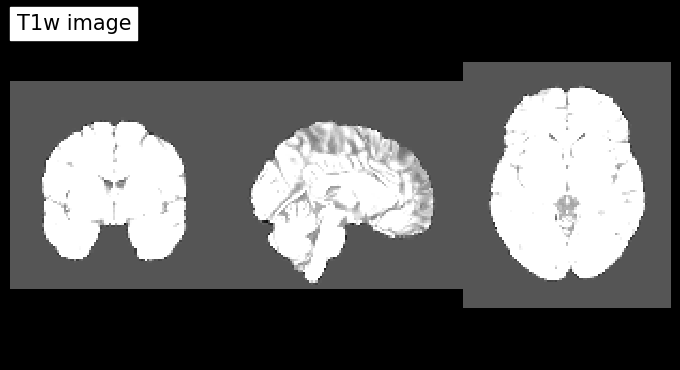

In [4]:

plot_anat(anat_path, title='T1w image', display_mode='ortho', dim=-1, draw_cross=False, annotate=False, cut_coords=(0, 0, 0))
        


### 0.2 Functional data

In [5]:

# list directory contents with extension 'nii.gz'
func_runs = os.listdir(funcdir_path)
func_runs = [f for f in func_runs if f.endswith('bold.nii.gz')]

# Sort the list
func_runs.sort()

print(func_runs)


['sub-01_ses-01_task-02a_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-01_ses-01_task-02a_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-01_ses-01_task-02a_run-3_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz', 'sub-01_ses-01_task-02a_run-4_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz']


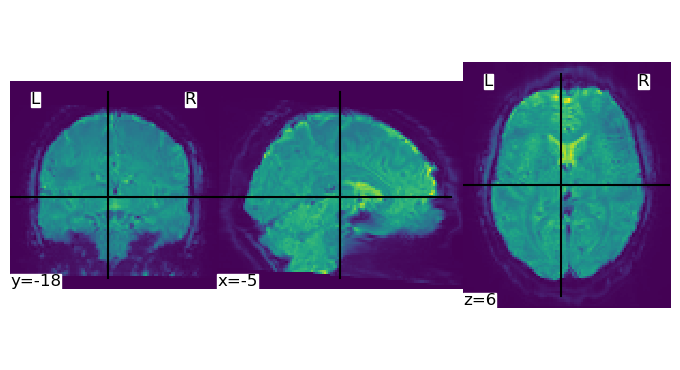

In [6]:
from nilearn.image import mean_img 

# Load the first functional image
func_image = image.load_img(os.path.join(funcdir_path,func_runs[0]))

mfunc_img = mean_img(func_image)

plot_img(mfunc_img)

#### 0.2.1 Events

In [7]:
fdir_events = [file for file in os.listdir(funcdir_path) if file.endswith('.tsv')]

f_events = [os.path.join(funcdir_path, f) for f in fdir_events]


In [8]:
f_events.sort()

In [9]:
f_events

['../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-1_events.tsv',
 '../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-2_events.tsv',
 '../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-3_events.tsv',
 '../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-4_events.tsv']

In [10]:
for fn in f_events:
    # Load the events.tsv file
    events = pd.read_table(fn)

    # Get the file name
    events_info = os.path.basename(fn)

    # Print the image information
    print(events_info) 
    
    # pd.read_table function is used to read a general delimited file into a pandas DataFrame
    print(events) 

sub-01_ses-01_task-02a_run-1_events.tsv
     onset  duration        trial_type
0     0.00     12.25             Noise
1    12.25     24.00        Tenderness
2    36.24      5.93             Noise
3    42.18     24.08        Tenderness
4    66.25     17.99             Noise
5    84.25     24.06            Wonder
6   108.30      5.98             Noise
7   114.28     23.97            Wonder
8   138.25     17.93             Noise
9   156.19     24.07         Nostalgia
10  180.26      6.37             Noise
11  186.62     23.63         Nostalgia
12  210.25     18.15             Noise
13  228.40     23.86      Peacefulness
14  252.26      5.94             Noise
15  258.20     24.07      Peacefulness
16  282.26     17.96             Noise
17  300.22     24.03     Transcendence
18  324.26      5.94             Noise
19  330.20     24.07     Transcendence
20  354.27     18.00             Noise
21  372.27     24.07           Sadness
22  396.33      5.99             Noise
23  402.32     24.01    

# 1 Creation of Input dataset and Target vectors 

In [11]:
from nilearn.image import index_img 

run_id = 0

image_set = {}
target_set = {}
group_set = {}

idx = 0

offset_st = 4 # offset for the onset time
offset_end = 2 # offset for the end block time

# for each events file 
for fn in f_events:

    print(os.path.join(funcdir_path,func_runs[run_id]), fn)
    
    # Load the events.tsv file
    events = pd.read_table(fn)

    # create one image per event 
    for i, row in events.iterrows():

        # Print the row information
        print(row) 

        # Extract the onset time
        onset = np.round(row['onset'])

        # Extract the duration
        duration = np.round(row['duration'])

        # Extract the trial_type
        trial_type = row['trial_type']

        # Print the row information
        print(onset, duration, trial_type) 

        # if duration greater than 10
        if duration > 10 and onset + duration + offset_end < 660:

            # array with onset to onset+duration
            i_idxs = np.arange(onset + offset_st, onset + duration + offset_end, 1, dtype=int)

            # create mean_img based on i_idxs
            mean_img_i = mean_img(index_img( 
                os.path.join(funcdir_path,func_runs[run_id]), 
                i_idxs))

            image_set[idx] = mean_img_i
            target_set[idx] = trial_type
            group_set[idx] = run_id

            idx += 1


    run_id += 1



../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz ../data/sub-01/ses-01/func/sub-01_ses-01_task-02a_run-1_events.tsv
onset           0.0
duration      12.25
trial_type    Noise
Name: 0, dtype: object
0.0 12.0 Noise
onset              12.25
duration            24.0
trial_type    Tenderness
Name: 1, dtype: object
12.0 24.0 Tenderness
onset         36.24
duration       5.93
trial_type    Noise
Name: 2, dtype: object
36.0 6.0 Noise
onset              42.18
duration           24.08
trial_type    Tenderness
Name: 3, dtype: object
42.0 24.0 Tenderness
onset         66.25
duration      17.99
trial_type    Noise
Name: 4, dtype: object
66.0 18.0 Noise
onset          84.25
duration       24.06
trial_type    Wonder
Name: 5, dtype: object
84.0 24.0 Wonder
onset         108.3
duration       5.98
trial_type    Noise
Name: 6, dtype: object
108.0 6.0 Noise
onset         114.28
duration       23.97
trial_type    Wonder
Name: 7, dtype: object

In [12]:
# size/shape of the image_set
print('Image set size: '+ str(len(image_set)))

# size/shape of the target_set
print('Target vector: '+ str(len(target_set)))

# print unique values in target_set
print('Labels: ')  
print(np.unique(list(target_set.values())))


# size/shape of the group_set
print('Run group vector: '+ str(len(group_set)))


Image set size: 108
Target vector: 108
Labels: 
['JoyfulActivation' 'Noise' 'Nostalgia' 'Peacefulness' 'Power' 'Sadness'
 'Tenderness' 'Tension' 'Transcendence' 'Wonder']
Run group vector: 108


In [13]:
# Remove the noise condition 

# create a new image_set, target_set and group_set
image_set_clean = {}
target_set_clean = {}
group_set_clean = {}

idx = 0

# for each image in image_set

for i in image_set:

    # if the target is not 'noise'
    if target_set[i] != 'Noise':
        image_set_clean[idx] = image_set[i]
        target_set_clean[idx] = target_set[i]
        group_set_clean[idx] = group_set[i]
        idx += 1

# size/shape of the image_set_clean
print('Image set size: '+ str(len(image_set_clean)))

# size/shape of the target_set_clean
print('Target vector: '+ str(len(target_set_clean)))


Image set size: 72
Target vector: 72


In [14]:
# change the target_set to target_set_clean
target_set = target_set_clean

# change the image_set to image_set_clean
image_set = image_set_clean

# change the group_set to group_set_clean
group_set = group_set_clean


In [15]:
# Save the image_set, target_set, and group_set in the derivatives directory inside the data directory
deriv_dir = os.path.join(src_dir, 'derivatives')

if not os.path.exists(deriv_dir):
    os.makedirs(deriv_dir)


# package folder structure
results_dir = os.path.join(deriv_dir, 'nilearn')

if not os.path.exists(results_dir):
    os.makedirs(results_dir)


data_fldr= os.path.join(results_dir, part_id, ses_id)

# if the directory for the participant and session does not exist, create it
if not os.path.exists(data_fldr):
    os.makedirs(data_fldr)


# concat images in list
X = nilearn.image.concat_imgs(list(image_set.values()))
print(X.shape)

# Save the image_set using nibabel.save and BIDS naming convention
nib.save(X, os.path.join(data_fldr, f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD.nii.gz'))

# Save the target_set to csv using pandas
pd.Series(target_set, name = 'target').to_csv(os.path.join(data_fldr, f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD_targets.csv'))

# Save the group_set to csv using pandas
pd.Series(group_set, name = 'group').to_csv(os.path.join(data_fldr, f'{part_id}_{ses_id}_task-02a-MVPA-12sBOLD_groups.csv'))




(97, 115, 97, 72)


# 2. Create masks

In [16]:
c_func_runs = [os.path.join(funcdir_path, f) for f in func_runs]

In [17]:
# Masking the data

from nilearn.masking import compute_epi_mask, compute_multi_epi_mask

mask_img = compute_multi_epi_mask(c_func_runs)

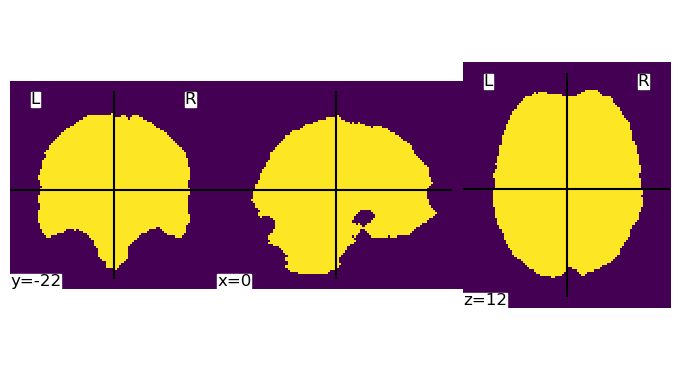

In [18]:
# plot mask image
plot_img(mask_img)

In [19]:
# save mask image
nib.save(mask_img, os.path.join(data_fldr, f'{part_id}_{ses_id}_task-02a-MVPA_multi-epi-mask.nii.gz'))